In [1]:
import pandas as pd
import re
from soynlp.normalizer import *
from transformers import ElectraTokenizer, TFElectraForSequenceClassification, TFElectraModel
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import create_optimizer
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
path = '/aiffel/aiffel/dktc/add_data/'
data = pd.read_csv(path+"result.csv")

data

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
4945,4945,일반 대화,"한달살기로 가보고 싶은 지역이 있어?\n 우리나라 중에서 말하는거야?\n 국내, 해..."
4946,4946,일반 대화,그런 스트레스는 키키 재밌는 드라마나 영화나 예능이 최고지!\n 난 요즘 갯마을 차...
4947,4947,일반 대화,나 저번에 소개팅했던 남자한테 연락이 왔어\n 그래? 뭐라고 왔니?\n 궁금하다 저...
4948,4948,일반 대화,우리나라 자국산 전투기 만드는거 알아?\n 전투기를 왜 만드는거야?\n 나라를 지키...


In [3]:
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

data['class'] = data['class'].apply(lambda x: label_map[x])
data.head()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
from transformers import ElectraTokenizer

# KoELECTRA 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

def get_token_length(text):
    tokens = tokenizer.tokenize(text)
    return tokens, len(tokens)

data['tokens'], data['tokens_len'] = zip(*data['conversation'].apply(get_token_length))
data.head()

,idx,class,conversation,tokens,tokens_len
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,"[지금, 너, 스스로, ##를, 죽여, ##달라, ##고, 애원, ##하, ##는,...",130
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,"[길, ##동, ##경찰, ##서, ##입니다, ., 9, ##시, 40, ##분,...",108
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,"[너, 되게, 귀여운, ##거, 알지, ?, 나, ##보, ##다, 작, ##은, ...",127
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,"[어이, 거기, 예, ?, ?, 너, 말, ##이, ##야, 너, ., 이리, 오라...",63
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,"[저기, ##요, 혹시, 날, ##이, 너무, 뜨겁, ##잖아요, ?, 저희, 회사...",240


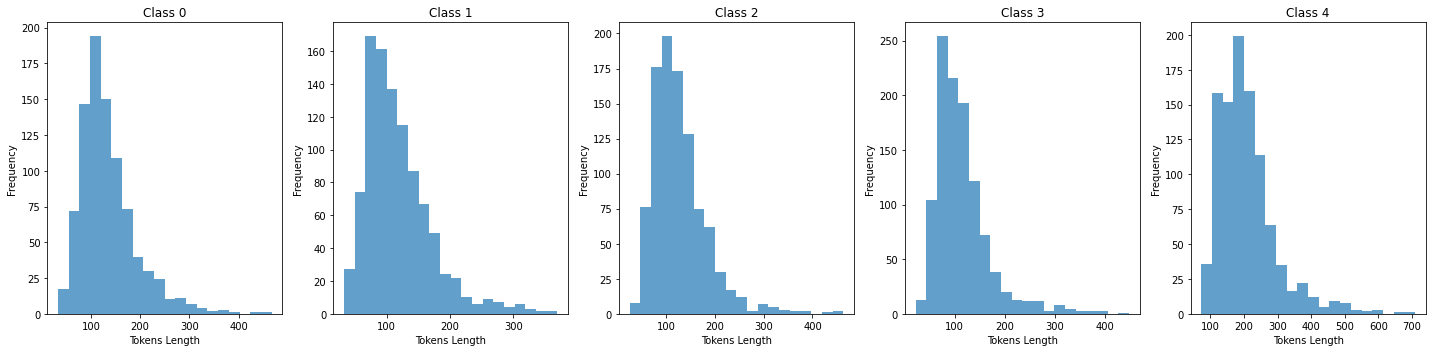

In [5]:
classes = label_map.values()
num_classes = len(classes)

plt.figure(figsize = (20, 5))
for i, cls in enumerate(classes):
    plt.subplot(1, num_classes, i + 1)
    plt.hist(data[data['class'] == cls]['tokens_len'], bins = 20, alpha = 0.7)
    plt.title(f'Class {cls}')
    plt.xlabel('Tokens Length')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
quantiles = data.groupby('class')['tokens_len'].quantile([0.25, 0.5, 0.75]).unstack()
print(quantiles)

        0.25   0.50   0.75
class                     
0       96.0  122.0  159.0
1       80.0  106.0  143.0
2       90.0  117.0  153.0
3       77.0  102.5  134.0
4      149.0  193.0  241.0


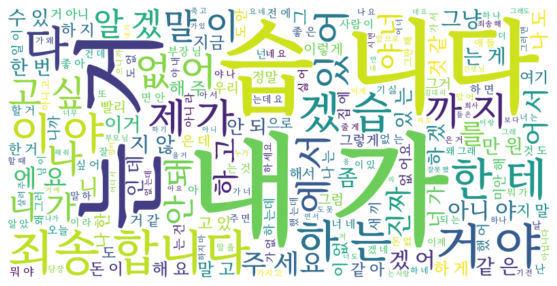

In [7]:
from wordcloud import WordCloud

# 비정상 데이터
filtered_data = data[data['class'] != 4]
text = ' '.join(filtered_data['tokens'].apply(lambda x: ' '.join(x)))

font_path = './MaruBuri-SemiBold.ttf'
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

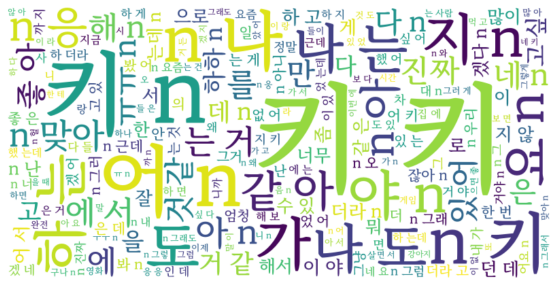

In [8]:
# 비정상 데이터
filtered_data = data[data['class'] == 4]
text = ' '.join(filtered_data['tokens'].apply(lambda x: ' '.join(x)))

font_path = './MaruBuri-SemiBold.ttf'
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
# data['conversation'][4000]

In [10]:
import re
def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'\\n|\.|키키|ㅠ|ㅜ', " ", sentence)
    sentence = re.sub(r'[\*]+', " ", sentence)  # ** 삭제 
    sentence = re.sub(r'\s+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [11]:
# tes = preprocess_sentence(data['conversation'][4000])
# tes

In [12]:
# text = tes
# words = text.split()                 # 공백을 기준으로 문자열을 분리하여 리스트로 만듦
# al = [] 
# for i in range(len(words) - 1):      # 2-gram이므로 리스트의 마지막에서 요소 한 개 앞까지만 반복함
# #     print(words[i], words[i + 1])    # 현재 문자열과 그다음 문자열 출력
#     a = words[i] + ' '+ words[i + 1]    # 현재 문자열과 그다음 문자열 출력    
#     al.append(a)

In [13]:
# data['conversation']

In [14]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size = 0.2, random_state = 526)

In [15]:
train_df

,idx,class,conversation,tokens,tokens_len
1069,1069,2,야 현과장 너 그 따위로 밖에 못하나 \n네? 무슨 일입니까?\n너 갑자기 직무 수...,"[야, 현, ##과, ##장, 너, 그, 따위, ##로, 밖에, 못하, ##나, 네...",114
2104,2104,2,야 너 인사 똑바로 안해?\n예? 아 못봤습니다 안녕하십니까 팀장님\n너 내가 예전...,"[야, 너, 인사, 똑바로, 안, ##해, ?, 예, ?, 아, 못, ##봤, ##...",143
2427,2427,3,야 너 왜 그렇게 생겼냐?\n내가 뭐 어때서.\n갑자기 얼굴 보니까 기분 나빠졌어....,"[야, 너, 왜, 그렇게, 생겼, ##냐, ?, 내, ##가, 뭐, 어때, ##서,...",92
4708,4708,4,넷마블이라는 회사 알아?\n 그럼 당연히 알지.\n 하긴 게임 하면 넷마블인데 모를...,"[넷마블, ##이, ##라는, 회사, 알아, ?, \, n, 그럼, 당연히, 알지,...",106
3036,3036,0,칼 내려 놓으세요\n너가 나 무시하고 있잖아\n선생님 진정하시고 제 말좀 들어보세요...,"[칼, 내려, 놓, ##으, ##세요, 너, ##가, 나, 무시, ##하, ##고,...",85
...,...,...,...,...,...
4396,4396,4,제주도 축구 팀 있제?\n 제주 유나이티드 있지 키키\n 아 그런 거 직관 가봄?\...,"[제주도, 축구, 팀, 있, ##제, ?, \, n, 제주, 유나이티, ##드, 있...",154
770,770,0,여보.흐윽. 제발 이러지마요.\n닥쳐! 이 년아. 내가 집에만 오면 니 얼굴 보는 ...,"[여보, ., 흐, ##윽, ., 제발, 이러, ##지마, ##요, ., 닥쳐, !...",199
963,963,0,저번에 말한 물건들 준비됐어?\n아니 선생님. 시간을 조금만 더 주세요.\n저번에도...,"[저번, ##에, 말, ##한, 물건, ##들, 준비, ##됐, ##어, ?, 아니...",105
1565,1565,3,저. 여기 임산부 배려석인데 . 죄송한데 . 자리 좀 비켜주 실 수 있으세요?\n임...,"[저, ., 여기, 임산부, 배려, ##석, ##인, ##데, ., 죄송, ##한,...",98


In [16]:
# 토큰화 전 텍스트 길이 확인
tokenized = tokenizer(
    train_df['conversation'].tolist(),
    truncation=False,
    padding=False,
    return_length=True
)

lengths = tokenized['length']
print(f"최대 시퀀스 길이: {max(lengths)}")
print(f"평균 시퀀스 길이: {sum(lengths)/len(lengths)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


최대 시퀀스 길이: 711
평균 시퀀스 길이: 142.39166666666668


In [17]:
test_df

,idx,class,conversation,tokens,tokens_len
3064,3064,3,야 10분 뒤에 소각장으로 나와\n왜?\n뭔 말이 많아 나오라면 나올 것이지\n저기...,"[야, 10, ##분, 뒤, ##에, 소각, ##장, ##으로, 나와, 왜, ?, ...",62
2941,2941,1,이거 못보던거네? 예쁘다\n어제 샀어 예쁘지? \n비쌌겠다. 그치? 비싸지? \n어...,"[이거, 못, ##보, ##던, ##거, ##네, ?, 예쁘, ##다, 어제, 샀,...",79
4344,4344,4,이번에 그 드라마 봤어?\n 무슨 드라마 얘기하는 거니\n 어둠 속으로 새로운 시즌...,"[이번, ##에, 그, 드라마, 봤, ##어, ?, \, n, 무슨, 드라마, 얘기...",114
4563,4563,4,아빠도 ** 많이 보고 싶어 하시죠\n ** ** 본지 오래돼서 가물가물 하시다고 ...,"[아빠, ##도, *, *, 많이, 보고, 싶, ##어, 하시, ##죠, \, n,...",235
3455,3455,1,나 이 립스틱 줘\n선물받은거라 안돼\n너 립스틱 많잖아 이거 하나만 줘\n얘는 진...,"[나, 이, 립스틱, 줘, 선물, ##받, ##은, ##거, ##라, 안, ##돼,...",82
...,...,...,...,...,...
2908,2908,0,아빠 또 취했어?\n어디서 어른한테 말대답이야\n뭐가\n죽여버릴 거야 너네 엄마랑 ...,"[아빠, 또, 취했, ##어, ?, 어디, ##서, 어른, ##한, ##테, 말, ...",63
4823,4823,4,지금 할리갈리 게임하는 중인데 생각보다 재미있네.\n 맞아. 재미있어. 스릴있지\n...,"[지금, 할리, ##갈, ##리, 게임, ##하, ##는, 중인, ##데, 생각, ...",158
2557,2557,1,지금 너 담배 피고 오는 거지? 내가 다봤어.\n 지금 무슨 소리 하는거야! 나 쓰...,"[지금, 너, 담배, 피고, 오, ##는, 거지, ?, 내, ##가, 다, ##봤,...",151
74,74,3,안녕하세요. 혹시 번호 알수있을까요?\n아니요 죄송해요.\n한번만 주세요.\n저 가...,"[안녕, ##하, ##세요, ., 혹시, 번호, 알, ##수, ##있, ##을까, ...",82


In [18]:
# 토큰화 전 텍스트 길이 확인
tokenized = tokenizer(
    test_df['conversation'].tolist(),
    truncation=False,
    padding=False,
    return_length=True
)

lengths = tokenized['length']
print(f"최대 시퀀스 길이: {max(lengths)}")
print(f"평균 시퀀스 길이: {sum(lengths)/len(lengths)}")


최대 시퀀스 길이: 586
평균 시퀀스 길이: 143.4010101010101


In [19]:
# KoELECTRA 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

SEQ_LEN = 50
# 데이터를 KoELECTRA 입력 형식으로 변환하는 함수 정의
def convert_to_input(df, tokenizer, max_length=SEQ_LEN, train_set = True):
    input_ids = []
    attention_masks = []
    
    if train_set:
        labels = []

    for i in range(len(df)):
        # .\\n키키ㅠㅜ 삭제
        sentence = preprocess_sentence(df.iloc[i]['conversation'])        
#         print('sentence', sentence)
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
#         print('encoded', encoded)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        if train_set:
            labels.append(df.iloc[i]['class'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    if train_set:
        labels = tf.convert_to_tensor(labels, dtype=tf.int32)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_masks
            }, labels
    else:
        return {
            'input_ids': input_ids,
            'attention_mask': attention_masks
            }

In [20]:
batch_size = 16

# 데이터셋 변환
train_inputs, train_labels = convert_to_input(train_df, tokenizer)
test_inputs, test_labels = convert_to_input(test_df, tokenizer)

# TF Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(batch_size)


In [21]:
print("Input IDs shape:", train_inputs['input_ids'].shape)
print("Attention Mask shape:", train_inputs['attention_mask'].shape)


Input IDs shape: (3960, 50)
Attention Mask shape: (3960, 50)


In [22]:
train_dataset

<BatchDataset shapes: ({input_ids: (None, 50), attention_mask: (None, 50)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [23]:
test_dataset

<BatchDataset shapes: ({input_ids: (None, 50), attention_mask: (None, 50)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [24]:
num_labels = len(label_map)

model = TFElectraForSequenceClassification.from_pretrained(
    "monologg/koelectra-base-v3-discriminator", num_labels = num_labels, from_pt = True)

# from transformers import TFElectraModel

# model = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

# model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

In [25]:
# 옵티마이저, 손실 함수 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [27]:
# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 모델 훈련
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


Epoch 1/10
248/248 [==============================] - 55s 188ms/step - loss: 1.7557 - accuracy: 0.1907 - val_loss: 1.6094 - val_accuracy: 0.1879
Epoch 2/10
248/248 [==============================] - 45s 180ms/step - loss: 1.6151 - accuracy: 0.1960 - val_loss: 1.6094 - val_accuracy: 0.1848
Epoch 3/10
248/248 [==============================] - 45s 183ms/step - loss: 1.6094 - accuracy: 0.2003 - val_loss: 1.6094 - val_accuracy: 0.1848
Epoch 4/10
248/248 [==============================] - 46s 186ms/step - loss: 1.6094 - accuracy: 0.1927 - val_loss: 1.6094 - val_accuracy: 0.1848


In [ ]:
# transformers                 4.30.2

In [ ]:
# 훈련 과정에서 얻은 history 객체에서 loss와 accuracy 데이터 추출
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# 그래프 그리기
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 모델 평가
eval_results = model.evaluate(test_dataset)
print(f"테스트 세트 정확도: {eval_results[1] * 100:.2f}%")

In [ ]:
# 평가
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()
true_labels = test_labels.numpy()

In [ ]:
# report = classification_report(true_labels, predicted_labels, target_names=label_map.keys(), output_dict=True)
# report_df = pd.DataFrame(report).transpose()
# report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
# report_df = report_df.round(4)
# report_df

In [ ]:
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}
labels = label_map.values()

cm = confusion_matrix(test_labels, predicted_labels)

# Heatmap으로 confusion matrix 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 검증 데이터에 대한 예측 및 분류 보고서
report = classification_report(test_labels, predicted_labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
report_df = report_df.round(4)
report_df